# Credit Card Fraud Detection System

It is important that banks are able to recognize fraudulent credit card transactions so that customers are not charged for items that they did not purchase. So I have built a model which is able to identity which activity is suspicious and possibly fraudulent.

   ### Content
    The datasets contains transactions made by credit cards in September 2013 by european cardholders.
    This dataset presents transactions that occurred in two days, where we have 492 frauds out of 284,807 transactions. The dataset is highly unbalanced, the positive class (frauds) account for 0.172% of all transactions.

    It contains only numerical input variables which are the result of a PCA transformation. Unfortunately, due to confidentiality issues, we cannot provide the original features and more background information about the data. Features V1, V2, … V28 are the principal components obtained with PCA, the only features which have not been transformed with PCA are 'Time' and 'Amount'. Feature 'Time' contains the seconds elapsed between each transaction and the first transaction in the dataset. The feature 'Amount' is the transaction Amount, this feature can be used for example-dependant cost-senstive learning. Feature 'Class' is the response variable and it takes value 1 in case of fraud and 0 otherwise.


`Note: The dataset was taken from Kaggle.`

In [1]:
# Importing Libraries
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

In [2]:
# Importing the Dataset
df = pd.read_csv("creditcard.csv")

Lets have a look at how much pre-processing is required.

In [3]:
# How many null values do we have?
print(df.isnull().sum().max())
# That is great

0


In [4]:
print(df['Class'].value_counts()[0]/len(df)*100)

99.82725143693798


This shows us that the data is highly skewed.
Lets take a look at this visually.

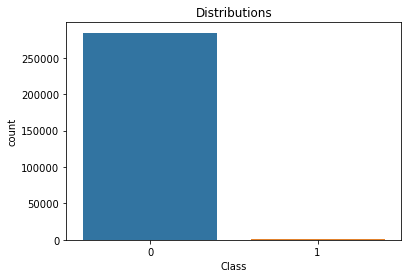

In [5]:
sns.countplot('Class', data=df)
plt.title("Distributions")
plt.show()

To manage this problem, we can create samples from the data where the distribution of the cases we have are nearly equal.

In [6]:
print(len(df.loc[df['Class']==1]))

# Shuffling and making the dataset equivalent
df = df.sample(frac=1)
fraud = df.loc[df['Class']==1]
not_fraud = df.loc[df['Class'] == 0][:492]
# Beacuse we know we have 492 fraud cases
distributed_df = pd.concat([fraud, not_fraud])
# shuffle
new_df = distributed_df.sample(frac=1, random_state=0)
new_df.head()

492


,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
42958,41313.0,-13.897206,6.344280,-14.281666,5.581009,-12.887133,-3.146176,-15.450467,9.060281,-5.486121,...,3.058082,0.941180,-0.232710,0.763508,0.075456,-0.453840,-1.508968,-0.686836,9.99,1
40952,40476.0,1.315771,-0.032971,-1.089771,-0.557242,2.030119,3.268061,-0.535246,0.808299,-0.052702,...,-0.313423,-1.068834,0.103964,0.992116,0.369468,0.110394,-0.028266,0.011803,1.79,0
215984,140308.0,-4.861747,-2.722660,-4.656248,2.502005,-2.008346,0.615422,-3.485680,1.878856,-1.116268,...,1.138876,1.033664,-0.806199,-1.511046,-0.191731,0.080999,1.215152,-0.923142,592.90,1
98891,66859.0,-2.349642,0.200796,0.885624,0.360821,-0.058513,-1.577691,0.657887,0.213853,-0.636051,...,-0.416789,-1.315058,-0.349873,0.714117,0.139631,0.019500,0.493997,-0.253080,135.58,0
7457,10135.0,1.155283,0.417287,0.412208,1.349081,-0.129768,-0.873308,0.276405,-0.399134,1.068081,...,-0.079084,0.020003,-0.144903,0.374440,0.690048,-0.376462,-0.013720,0.025088,52.50,0


Lets see how the new dataframe looks like.

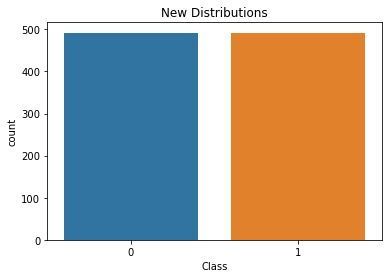

In [7]:
sns.countplot('Class', data=new_df)
plt.title("New Distributions")
plt.show()

Lets finally scale the data.<br>
Most of the data looks to be scaled however the Time and Amount feature need to be scaled.<br>
`Note: Read that Robust Scalar performs much better in case of possible outliers`

In [8]:
from sklearn.preprocessing import StandardScaler, RobustScaler
amt_scaler = StandardScaler()
time_scaler = RobustScaler()

new_df['Time'] = time_scaler.fit_transform(new_df['Time'].values.reshape(-1, 1))
new_df['Amount'] = time_scaler.fit_transform(new_df['Amount'].values.reshape(-1, 1))

Lets now look at the realtion between the features.

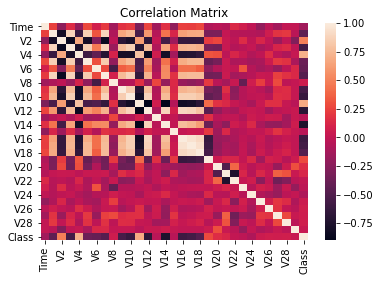

In [9]:
corr = new_df.corr()
sns.heatmap(corr)
plt.title('Correlation Matrix')
plt.show()

The Correlation matrix does tell us a lot about the features, but perhaps not enough. I however will not be dwelling into them as I do not have much information about the type of data they represent.<br>
`A good practice would have been to plot the highly correlated features to hopefully find something useful`

# Making the model

In [10]:
X = new_df.iloc[:, :-1].values
y = new_df.iloc[:, -1].values

from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.25)

You could use Grid Search CV to find the best Classifier for the job.<br>
I tested the below mentioned classifiers individually and found that Logistic Regression worked best, but please, don't take my word for it and give it a go yourself.<br>
`Classifiers used:`<br>
`classifiers = ["Logistic Regression", "Knn", "SVM", "kernel SVM", "Naive bayes","Decision Tree", "Random Forest"]`

I was going to use a few metrics quite a lot so I just made a function for it.

In [11]:
def metric(classifier, X_train, y_train, y_test, y_pred):
    from sklearn.metrics import confusion_matrix
    from sklearn.model_selection import cross_val_score
    cm = confusion_matrix(y_test, y_pred)

    # Applying k-Fold Cross Validation
    accuracies = cross_val_score(classifier, X_train, y_train, cv=10, n_jobs=-1)
    print(accuracies.mean())
    print(accuracies.std())
    return cm

In [12]:
from sklearn.linear_model import LogisticRegression
classifier = LogisticRegression()
classifier.fit(X_train, y_train)

# Predicting test set using classifier
y_pred = classifier.predict(X_test)
cm = metric(classifier, X_train, y_train, y_test, y_pred)
print(cm)
print(classifier)

0.9444465012958163
0.014133129877165347
[[103   6]
 [ 10 127]]
LogisticRegression()


To check for overfitting (Quite possible in this dataset) I took the help of the Cross Validation Score

In [13]:
from sklearn.model_selection import cross_val_score
cvs = cross_val_score(classifier, X_train, y_train, cv=10)
print("Cross Validation Score", cvs.mean())

Cross Validation Score 0.9444465012958163


The high accuracy and Cross Validation Score made me confident in the model.

In [14]:
from sklearn.model_selection import cross_val_predict
from sklearn.metrics import roc_auc_score
prediction = cross_val_predict(classifier, X_train, y_train, cv=5, method="decision_function")
print('Logistic Regression: ', roc_auc_score(y_train, prediction))

Logistic Regression:  0.9776192402456516


In [15]:
from sklearn.metrics import recall_score, precision_score, f1_score, accuracy_score
print('Recall Score: {:.2f}'.format(recall_score(y_test, y_pred)))
print('Precision Score: {:.2f}'.format(precision_score(y_test, y_pred)))
print('F1 Score: {:.2f}'.format(f1_score(y_test, y_pred)))
print('Accuracy Score: {:.2f}'.format(accuracy_score(y_test, y_pred)))

Recall Score: 0.93
Precision Score: 0.95
F1 Score: 0.94
Accuracy Score: 0.93


But all these were done on the sample, how well would it do on the dataset as a whole?

In [16]:
df['Time'] = time_scaler.fit_transform(df['Time'].values.reshape(-1, 1))
df['Amount'] = time_scaler.fit_transform(df['Amount'].values.reshape(-1, 1))

y_pred = classifier.predict(df.iloc[:, :-1].values)
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(df.iloc[:, -1].values, y_pred)
print(cm)
print("-"*40)
print('Recall Score: {:.2f}'.format(recall_score(df.iloc[:, -1].values, y_pred)))
print('Precision Score: {:.2f}'.format(precision_score(df.iloc[:, -1].values, y_pred)))
print('F1 Score: {:.2f}'.format(f1_score(df.iloc[:, -1].values, y_pred)))
print('Accuracy Score: {:.2f}'.format(accuracy_score(df.iloc[:, -1].values, y_pred)))

[[275116   9199]
 [    38    454]]
----------------------------------------
Recall Score: 0.92
Precision Score: 0.05
F1 Score: 0.09
Accuracy Score: 0.97


### Confusion Matrix
The confusion matrix shows us that the model performed well, and it did manage to find most of the fraudulent cases. No surprises there, but still the model could not correct flag quite a lot of cases from the fraudulent label (Type II error)
### Precision Score and F1 Score
The score in this case is abysmal, but that is due to the highly skewed nature of the dataset itself. The weighted average thus plumets the scores.

`I still wonder if the model is overfitted`

# Making a deep neural network

Just to see how a artificial neural network would perform in comparison to the above model.

In [17]:
import keras
from keras.models import Sequential
from keras.layers import Dense

# Initializing the ANN
ann = Sequential()
input_shape = X_train.shape[1]

# Adding layers
ann.add(keras.Input(shape = (input_shape, )))
ann.add(Dense(32, activation = 'relu'))
ann.add(Dense(16, activation = 'relu'))
ann.add(Dense(2, activation = 'sigmoid'))

# Compiling the classifier
ann.compile(optimizer='adam', loss="sparse_categorical_crossentropy",
                   metrics=['accuracy'])

ann.fit(X_train, y_train, validation_split=0.2, batch_size=25, epochs=20,
        shuffle=True, validation_data = (X_test, y_test))

# Scoring the model
score = ann.evaluate(X_test, y_test)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

Epoch 1/20
24/24 [==============================] - 0s 8ms/step - loss: 1.1015 - accuracy: 0.5356 - val_loss: 0.4655 - val_accuracy: 0.7230
Epoch 2/20
24/24 [==============================] - 0s 3ms/step - loss: 0.4388 - accuracy: 0.7712 - val_loss: 0.4045 - val_accuracy: 0.8108
Epoch 3/20
24/24 [==============================] - 0s 3ms/step - loss: 0.3771 - accuracy: 0.8644 - val_loss: 0.3553 - val_accuracy: 0.8784
Epoch 4/20
24/24 [==============================] - 0s 3ms/step - loss: 0.3197 - accuracy: 0.9085 - val_loss: 0.3137 - val_accuracy: 0.9054
Epoch 5/20
24/24 [==============================] - 0s 3ms/step - loss: 0.2687 - accuracy: 0.9186 - val_loss: 0.2822 - val_accuracy: 0.9054
Epoch 6/20
24/24 [==============================] - 0s 3ms/step - loss: 0.2289 - accuracy: 0.9254 - val_loss: 0.2569 - val_accuracy: 0.9054
Epoch 7/20
24/24 [==============================] - 0s 3ms/step - loss: 0.1996 - accuracy: 0.9271 - val_loss: 0.2334 - val_accuracy: 0.9257
Epoch 8/20
24/24 [==

Making the we would get a probability of each class so choosing the threshold for the model can be critical. I eventually chose a lower threshold so as to minimize the number of type II errors, but the threshold can be fine tuned as per requirement.

In [18]:
# Making the predictions
y_pred = ann.predict(X_test)
ann_pred = []
for p in y_pred:
    if p[0] > 0.35:
        ann_pred.append(0)
    else:
        ann_pred.append(1)
        

# Making the Confusion Matrix
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(y_test, ann_pred)
print(cm)

[[ 98  11]
 [  6 131]]


For comparision the confusion matrix for the Logistic Regression model: <br>
[[123   8]<br>[  9 106]]

We see that the overall accuracy in this case is so because we chose a low threshold for the Neural Network.<br>
Let's see the accuracy if the threshold was 50%.

In [19]:
y_pred = ann.predict(X_test)
ann_pred = []
for p in y_pred:
    if p[0] > 0.5:
        ann_pred.append(0)
    else:
        ann_pred.append(1)
        

# Making the Confusion Matrix
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(y_test, ann_pred)
print(cm)

[[ 93  16]
 [  5 132]]


So you can see that choosing the right threshold for the predictions can be critical.

In [20]:
# Analysing the results
print('-'*45)
print('Recall Score: {:.2f}'.format(recall_score(y_test, ann_pred)))
print('Precision Score: {:.2f}'.format(precision_score(y_test, ann_pred)))
print('F1 Score: {:.2f}'.format(f1_score(y_test, ann_pred)))
print('Accuracy Score: {:.2f}'.format(accuracy_score(y_test, ann_pred)))

# placing the model onto the whole dataset
y_pred = ann.predict(df.iloc[:, :-1].values)
ann_pred = []
for p in y_pred:
    if p[0] > 0.35 :
        ann_pred.append(0)
    else:
        ann_pred.append(1)

cm = confusion_matrix(df.iloc[:, -1].values, ann_pred)
print(cm)
print("-"*40)
print('Recall Score: {:.2f}'.format(recall_score(df.iloc[:, -1].values, ann_pred)))
print('Precision Score: {:.2f}'.format(precision_score(df.iloc[:, -1].values, ann_pred)))
print('F1 Score: {:.2f}'.format(f1_score(df.iloc[:, -1].values, ann_pred)))
print('Accuracy Score: {:.2f}'.format(accuracy_score(df.iloc[:, -1].values, ann_pred)))

---------------------------------------------
Recall Score: 0.96
Precision Score: 0.89
F1 Score: 0.93
Accuracy Score: 0.91
[[252296  32019]
 [    19    473]]
----------------------------------------
Recall Score: 0.96
Precision Score: 0.01
F1 Score: 0.03
Accuracy Score: 0.89


In this particular case we only missed a few Fraudulent cases. But the cost of flaging wat too many normal transactions as Fraud.<br> Let's again see what happens if we use a different threshold.

In [21]:
# placing the model onto the whole dataset
y_pred = ann.predict(df.iloc[:, :-1].values)
ann_pred = []
for p in y_pred:
    if p[0] > 0.5 :
        ann_pred.append(0)
    else:
        ann_pred.append(1)

cm = confusion_matrix(df.iloc[:, -1].values, ann_pred)
print(cm)
print("-"*40)
print('Recall Score: {:.2f}'.format(recall_score(df.iloc[:, -1].values, ann_pred)))
print('Precision Score: {:.2f}'.format(precision_score(df.iloc[:, -1].values, ann_pred)))
print('F1 Score: {:.2f}'.format(f1_score(df.iloc[:, -1].values, ann_pred)))
print('Accuracy Score: {:.2f}'.format(accuracy_score(df.iloc[:, -1].values, ann_pred)))

[[230715  53600]
 [    10    482]]
----------------------------------------
Recall Score: 0.98
Precision Score: 0.01
F1 Score: 0.02
Accuracy Score: 0.81


# Conclusion

Implementing sub-sampling on our data was crucial to help us work with the highly imbalanced data. Yet still the Neural Network could not predict the cases well enough in comparrision to the Logisitic Regression. Removal of outliers and a much thorough cleaning of the dataset could have resulted in a much better model. <br>
I still raise my concern for overfitting and will say that the number of fradulent cases aren't enough for me to have very high confidence in either of the models. <br>
The Area Under the Precision-Recall Curve (AUPRC) and ROC can give insights to the models performance and I might add them later.